In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2

In [2]:
# 仿真运动模糊
def motion_process(image_size, motion_angle):
    PSF = np.zeros(image_size)
    print(image_size)
    center_position = (image_size[0] - 1) / 2
    print(center_position)

    slope_tan = math.tan(motion_angle * math.pi / 180)
    slope_cot = 1 / slope_tan
    if slope_tan <= 1:
        for i in range(15):
            offset = round(i * slope_tan)  # ((center_position-i)*slope_tan)
            PSF[int(center_position + offset), int(center_position - offset)] = 1
        return PSF / PSF.sum()  # 对点扩散函数进行归一化亮度
    else:
        for i in range(15):
            offset = round(i * slope_cot)
            PSF[int(center_position - offset), int(center_position + offset)] = 1
        return PSF / PSF.sum()


In [3]:
# 对图片进行运动模糊
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)  # 进行二维数组的傅里叶变换
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred

In [4]:
#维纳滤波
def wiener(input, PSF, eps, K=0.01):
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps
    PSF_fft_1 = np.conj(PSF_fft) / (np.abs(PSF_fft) ** 2 + K)
    result = fft.ifft2(input_fft * PSF_fft_1)
    result = np.abs(fft.fftshift(result))
    return result

In [5]:
#图像标准化
def normal(array):
    array = np.where(array < 0, 0, array)
    array = np.where(array > 255, 255, array)
    array = array.astype(np.int16)
    return array

In [6]:
def main(gray):
    channel = []
    img_h, img_w = gray.shape[:2]
    PSF = motion_process((img_h, img_w), 60)  # 进行运动模糊处理
    blurred = np.abs(make_blurred(gray, PSF, 1e-3))
    result_wiener = wiener(blurred, PSF, 1e-3)  # 维纳滤波
    blurred_noisy = blurred + 0.1 * blurred.std() * \
                    np.random.standard_normal(blurred.shape)  # 添加噪声,standard_normal产生随机的函数
    wiener_mo2no = wiener(blurred_noisy, PSF, 0.1 + 1e-3)  # 对添加噪声的图像进行维纳滤波
    channel.append((normal(blurred),  normal(result_wiener),
                    normal(blurred_noisy),  normal(wiener_mo2no)))
    return channel

In [7]:
if __name__ == '__main__':
    image = cv2.imread('lena.jpg')
    b_gray, g_gray, r_gray = cv2.split(image.copy())
    Result = []
    for gray in [b_gray, g_gray, r_gray]:
        channel = main(gray)
        Result.append(channel)
    blurred = cv2.merge([Result[0][0][0], Result[1][0][0], Result[2][0][0]])
    result_wiener = cv2.merge([Result[0][0][1], Result[1][0][1], Result[2][0][1]])
    blurred_noisy = cv2.merge([Result[0][0][2], Result[1][0][2], Result[2][0][2]])
    wiener_mo2no = cv2.merge([Result[0][0][3], Result[1][0][3], Result[2][0][3]])

(640, 640)
319.5
(640, 640)
319.5
(640, 640)
319.5


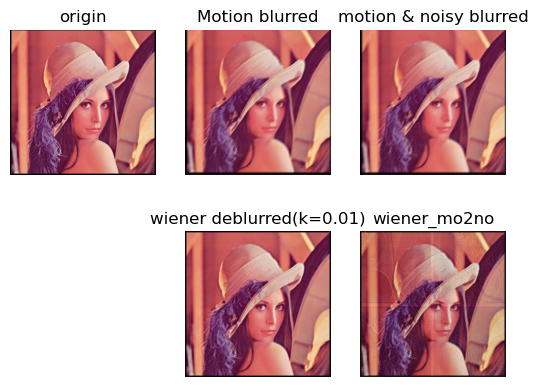

In [8]:
plt.subplot(231),plt.title("origin"),plt.axis('off'),plt.imshow(np.flip(image, axis=2))
plt.subplot(232), plt.title("Motion blurred"), plt.axis('off'), plt.imshow(np.flip(blurred, axis=2))
plt.subplot(235), plt.title("wiener deblurred(k=0.01)"), plt.axis('off'), plt.imshow(np.flip(result_wiener, axis=2))
plt.subplot(233), plt.title("motion & noisy blurred"), plt.axis('off'), plt.imshow(np.flip(blurred_noisy, axis=2))
plt.subplot(236), plt.title("wiener_mo2no"), plt.axis('off'), plt.imshow(np.flip(wiener_mo2no, axis=2))
plt.show()
